<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector



# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2021-05-14 09:21:47--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2021-05-14 09:21:47 (58.1 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2021-05-14 09:21:47--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 1.19 ms (started: 2021-05-14 09:21:52 +00:00)


The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [2]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2021-05-14 09:21:52--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2021-05-14 09:21:53--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  30.7MB/s    in 5

Differently than KMeans, isolation forests do not need any scaling.

# Tune the Precision-Recall curve and the ROC curve

We will apply isolation forests on the credit card fraud dataset, already used in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb). A similar notebook can be found in [Kaggle](https://www.kaggle.com/amarnayak/testing-isolation-forest-for-fraud-detection). 

 As in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb), we separate training and test set.

In [3]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = IsolationForest()

time: 264 ms (started: 2021-05-14 09:22:00 +00:00)


Our approach is unsupervised, so we **don't use y into fit(..)**

In [4]:
model.fit(X_train)
anomaly_scores = 0.5 - model.decision_function(X_train)

time: 6.91 s (started: 2021-05-14 09:22:01 +00:00)


In the previous code, we shift by 0.5 and we invert the sign to obtain the anomaly score described in the original paper of Isolation Forests, which also corresponds to what I wrote in my slides. These shift and sign inversion is done to correct scikit learn internal computation (see [this post](https://stats.stackexchange.com/a/350893/161064)).

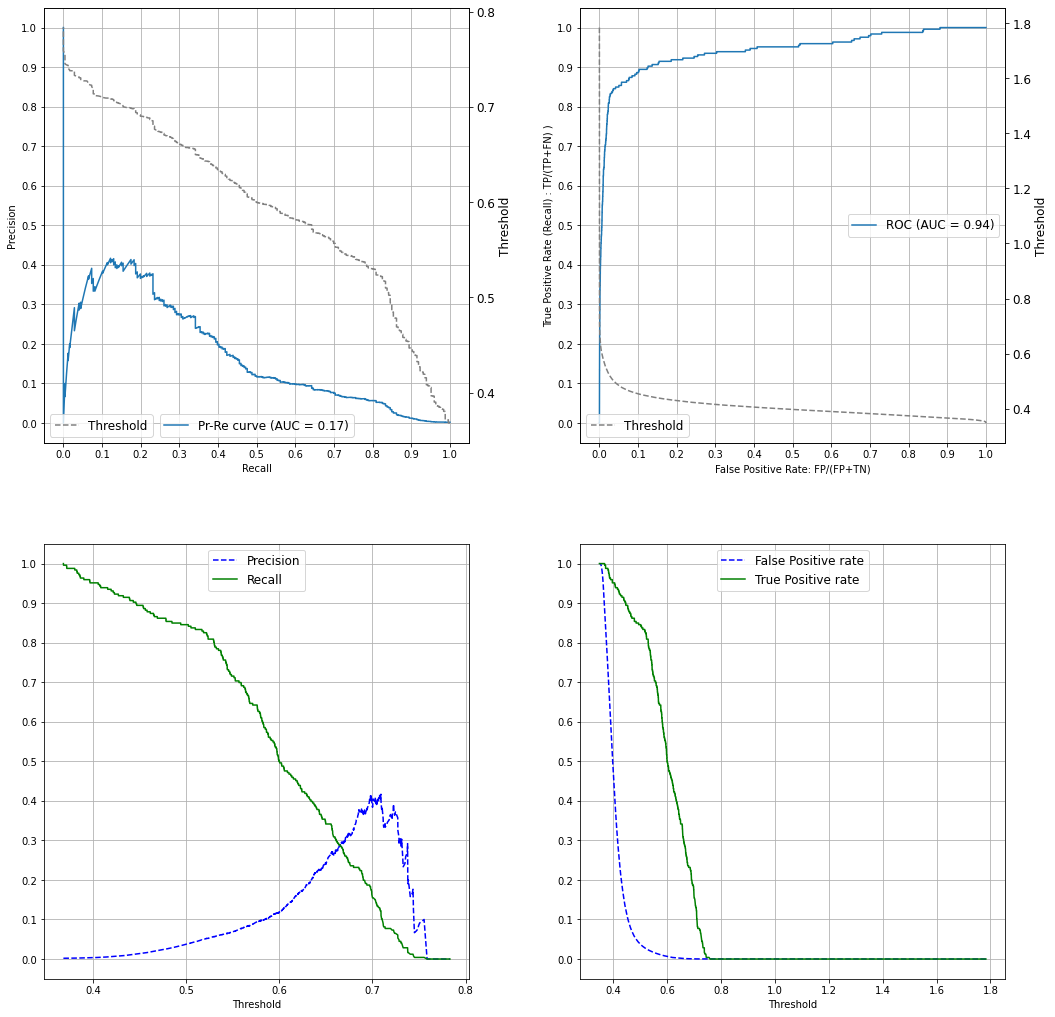

In [5]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Our isolation tree is still bad. The AUC of the precision-recall and ROC curves can be improved

### Number of trees

Increasing the number of trees always improves performance

In [6]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)


time: 1.53 s (started: 2021-05-14 09:22:08 +00:00)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 9.47 s (started: 2021-05-14 09:22:09 +00:00)


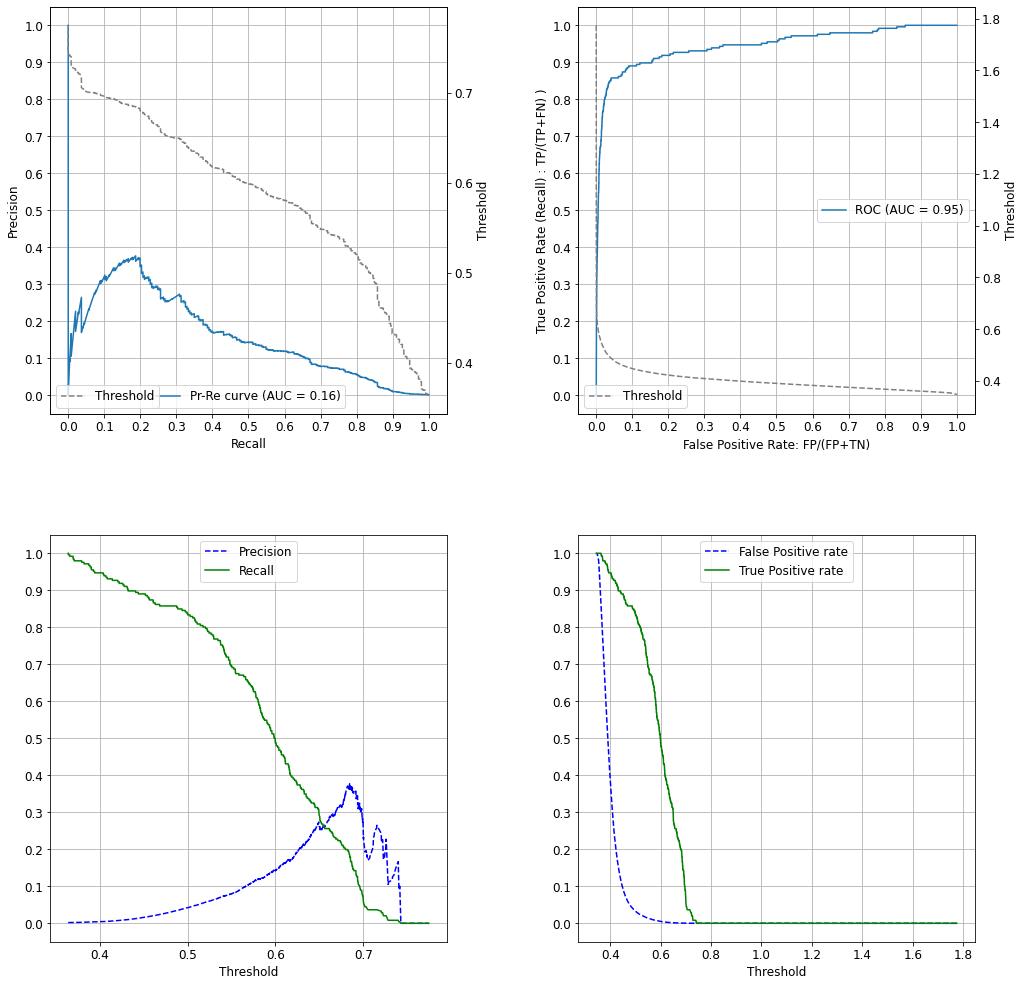

time: 26.9 s (started: 2021-05-14 09:22:19 +00:00)


In [7]:
anomaly_scores = 0.5 - model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

### Others

GridSearch from `sklearn` is not simple (however not impossible) to apply. It is more simple to make a grid search manually

In [8]:
iforest = IsolationForest(n_estimators=500)

for max_features in [1, 15, 29]:
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = 0.5 - model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.1554807662884762
max_fetaures: 1 ; max_samples: 47723 auc_score: 0.20355469917939423
max_fetaures: 1 ; max_samples: 95190 auc_score: 0.1956571483808927
max_fetaures: 15 ; max_samples: 256 auc_score: 0.15042149906743724
max_fetaures: 15 ; max_samples: 47723 auc_score: 0.22126354642389168
max_fetaures: 15 ; max_samples: 95190 auc_score: 0.23036654280846913
max_fetaures: 29 ; max_samples: 256 auc_score: 0.13996559969003916
max_fetaures: 29 ; max_samples: 47723 auc_score: 0.22654100539764696
max_fetaures: 29 ; max_samples: 95190 auc_score: 0.23050696911613683
time: 6min 26s (started: 2021-05-14 09:22:46 +00:00)


Let's evaluate the best configuration we found

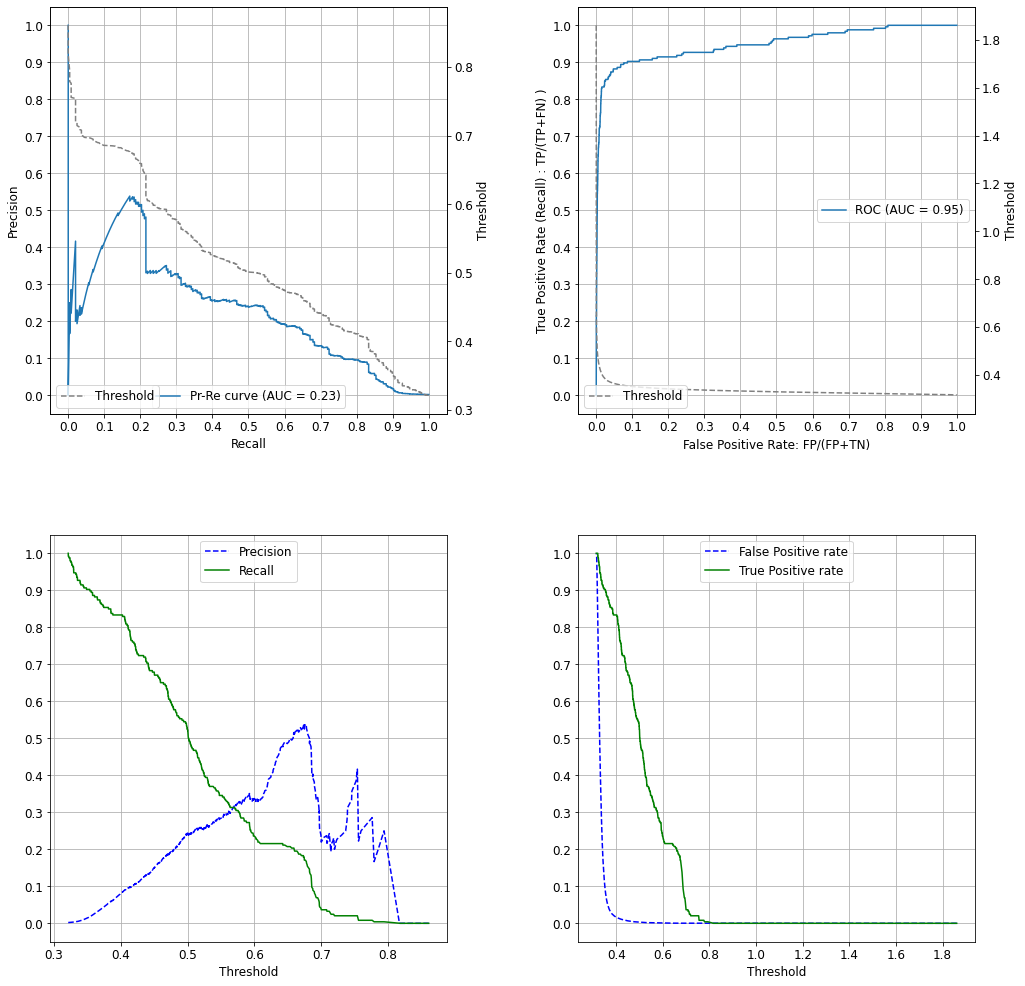

time: 54.3 s (started: 2021-05-14 09:29:12 +00:00)


In [9]:
n_estimators=500
max_features = 29
max_samples = 47723

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = 0.5 - model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

Note that `auc_score` is different, since isolation forests have a lot of randomness.

No real improvement. Increase further the number of trees.

In [10]:
n_estimators = 1500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=29, max_samples=47723, n_estimators=1500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 53 s (started: 2021-05-14 09:30:06 +00:00)


In [11]:

anomaly_scores = 0.5 - model.decision_function(X_train)

time: 1min 42s (started: 2021-05-14 09:30:59 +00:00)


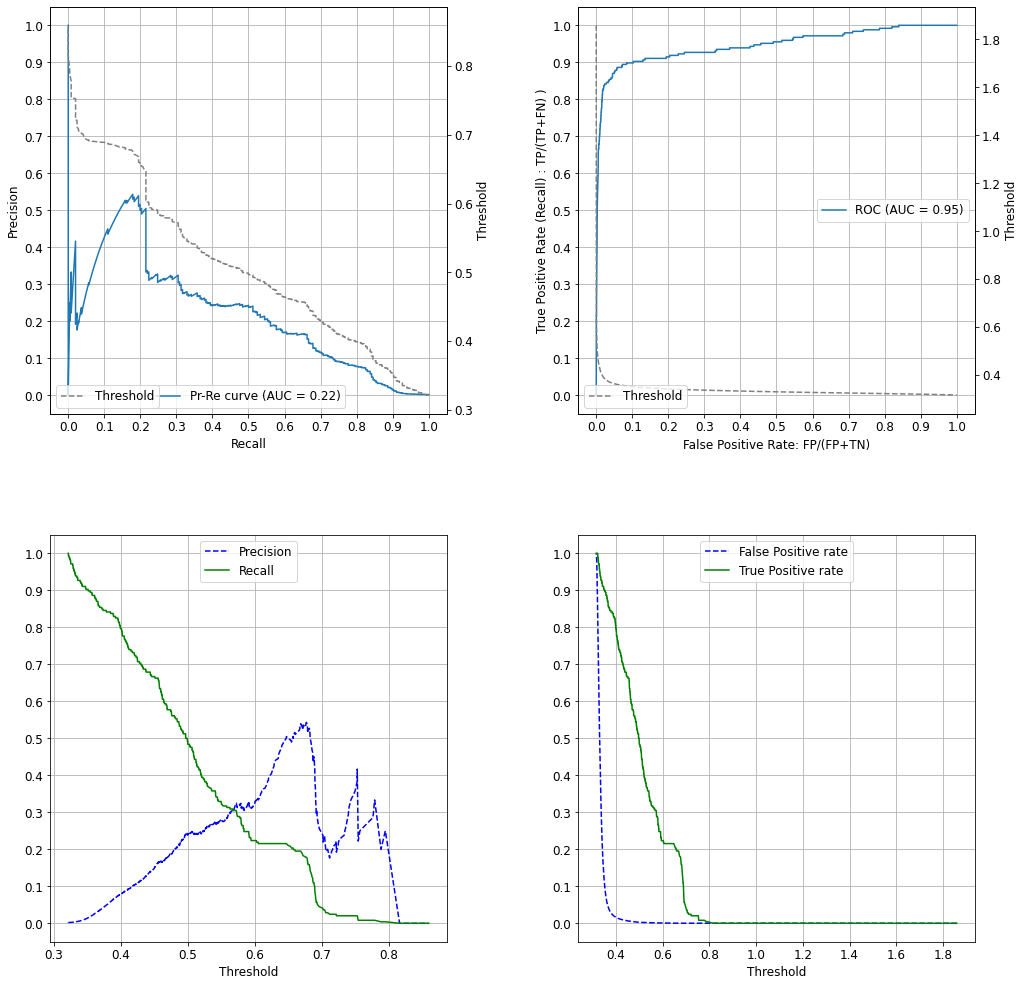

time: 1.6 s (started: 2021-05-14 09:32:42 +00:00)


In [12]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Fix the threshold

A good threshold could be:

Precision= 0.014147336222278869
Recall= 0.9024390243902439
False Positive Rate =  0.10882334320504794
True Positive Rate =  0.9024390243902439


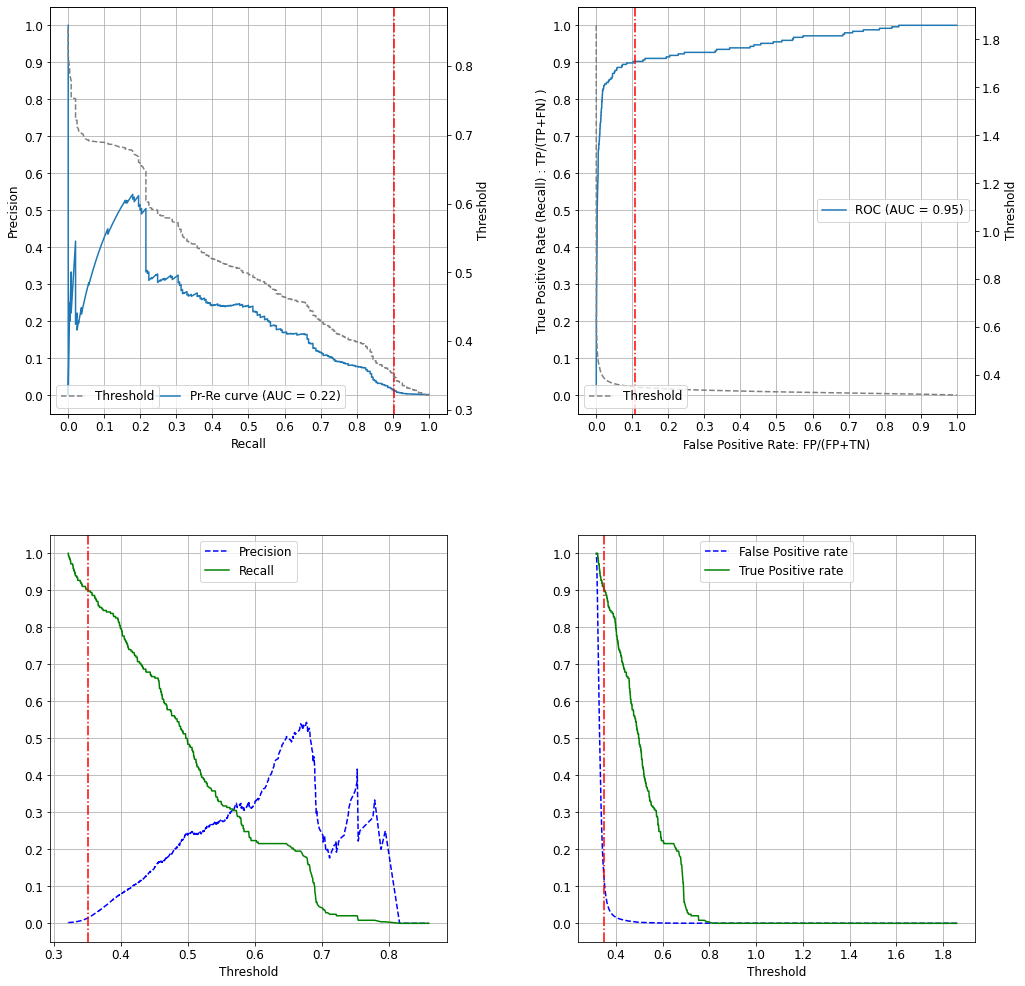

time: 2.57 s (started: 2021-05-14 09:32:43 +00:00)


In [13]:
threshold_selected = 0.35

evaluate_anomaly_detector(y_train, anomaly_scores, 
                          threshold_selected=threshold_selected)

But the false positive rate is too high. We need to renounce to some recall

Precision= 0.059554784619832324
Recall= 0.8373983739837398
False Positive Rate =  0.02288315031971693
True Positive Rate =  0.8373983739837398


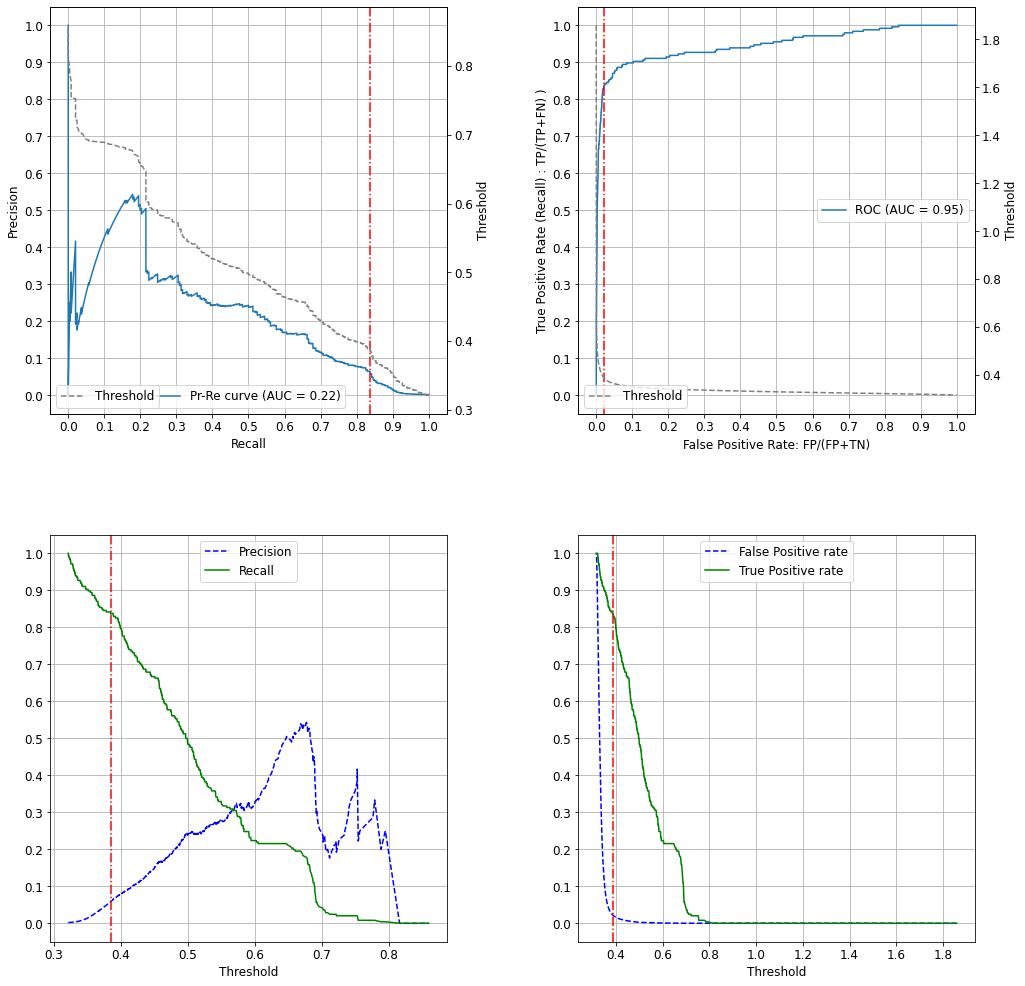

time: 2.54 s (started: 2021-05-14 09:32:46 +00:00)


In [14]:
threshold_selected = 0.385

evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

With this choice
* We find 84% of frauds
* We raise false alarms for 2% of normal activities

# Test


In [15]:
model.fit(X_test)
an_scores = 0.5 - model.decision_function(X_test)

time: 2min 39s (started: 2021-05-14 09:32:49 +00:00)


In [16]:
y_pred = (an_scores >= threshold_selected)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("precision=", precision)
print('recall=', recall)
print('false positive rate=', fpr)


precision= 0.054257319366102605
recall= 0.8211382113821138
false positive rate= 0.02476821564737827
time: 578 ms (started: 2021-05-14 09:35:28 +00:00)


Normalized confusion matrix
[[0.97523178 0.02476822]
 [0.17886179 0.82113821]]


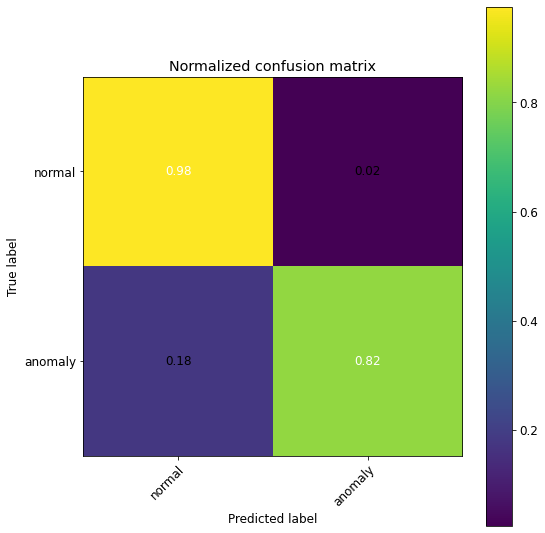

time: 675 ms (started: 2021-05-14 09:35:28 +00:00)


In [17]:
class_names= np.array( ['normal', 'anomaly'] )
plot_conf_mat(y_test, y_pred, class_names)

# Other code from the web
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf